## IBM Data Science Course Capstone Project. Battle of Neighborhoods.




by A.Rakhmetov






## 1. Download and Explore Dataset

#### Parsing the Toronto postal codes data from Wikipedia site:

In [1]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests


wiki_page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(wiki_page,'html.parser')

#The html table with postal codes:
My_table = soup.find('table', class_='wikitable sortable')


#### Preparing the 2D NumPy array for the dataframe operations in Pandas:

In [2]:

List=[]
for cell in My_table.find_all('td'):
    List.append(cell.text.replace('\n',''))
   
data = np.reshape(np.array(List), (-1,3))

print(data.shape)
data[0:5]

(289, 3)


array([['M1A', 'Not assigned', 'Not assigned'],
       ['M2A', 'Not assigned', 'Not assigned'],
       ['M3A', 'North York', 'Parkwoods'],
       ['M4A', 'North York', 'Victoria Village'],
       ['M5A', 'Downtown Toronto', 'Harbourfront']], dtype='<U49')

#### Implementing and pre-processing the dataframe according to the requirements:

In [3]:
# Creating the dataframe out of the numpy array:
df = pd.DataFrame({'PostalCode':data[:,0], 'Borough':data[:,1], 'Neighborhood':data[:,2]})

#Getting rid of "Not assigned" cells in the 'Borough' and 'Neighborhood' columns:
df = df[df.Borough != "Not assigned"]
df['Neighborhood'] = np.where(df['Neighborhood']=='Not assigned', df['Borough'], df['Neighborhood'])

# Grouping the Neighborhoods in lists according to the postal codes:
df = df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(list).reset_index()

# Merging the lists into one string separated with commas:
df['Neighborhood'] = df['Neighborhood'].str.join(', ')


df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [4]:
df.shape

(103, 3)

#### Getting the geospatial coordinates of each Postal Code:

In [5]:
gdf=pd.read_csv('http://cocl.us/geospatial_data')
gdf.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
# Merging the dataframes in one:

toronto_df = pd.DataFrame(pd.merge(df,gdf, left_on = 'PostalCode', right_on = 'Postal Code').drop('Postal Code', 1))

toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [7]:
toronto_df.shape

(103, 5)

## 2. Explore Neighborhoods in the City of Toronto

#### Creating the map of Toronto City.

Before we import all libraries we need:

In [8]:
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    cryptography-2.4.2         |   py36h1ba5d50_0         618 KB
    openssl-1.1.1a             |    h14c3975_1000         4.0 MB  conda-forge
    libarchive-3.3.3           |       h5d8350f_5         1.5 MB
    grpcio-1.16.1              |   py36hf8bcb03_1         1.1 MB
    geopy-1.18.1               |             py_0          51 KB  conda-forge
    conda-4.6.2                |           py36_0         869 KB  conda-forge
    libssh2-1.8.0              |                1         239 KB  conda-forge
    python-3.6.8               |       h0371630_0        34.4 MB
    ------------------------------------------------------------
      

In [9]:
# Using geopy library to get coordinates of Toronto City:
address = 'Toronto, ON'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


The geograpical coordinate of Toronto City are 43.653963, -79.387207.


In [10]:
# Creating the map of Toronto using coordinates:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)


# adding markers of postal codes to the map:
for lat, lng, borough, postalcode in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['PostalCode']):
    label = '{}, {}'.format(postalcode, borough)
    label = folium.Popup(label, parse_html=True)
    if borough == 'Etobicoke':
        cvet = 'Red'
    else: cvet = 'Blue'
        
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=cvet,
        fill=True,
        fill_color= cvet,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [11]:
boroughs = toronto_df.groupby('Borough')['PostalCode'].count()
boroughs

Borough
Central Toronto      9
Downtown Toronto    18
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Queen's Park         1
Scarborough         17
West Toronto         6
York                 5
Name: PostalCode, dtype: int64

## 3. Analyzing Neighborhoods in Etobicoke.

To analyze only Etobicoke borough we condider the boroughs with the word 'Etobicoke' in the name:

In [12]:
tdf = toronto_df[toronto_df['Borough'].str.contains("Etobicoke")].reset_index()
print(tdf.shape)
tdf

(12, 6)


,index,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,88,M8V,Etobicoke,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321
1,89,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484
2,90,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
3,91,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So...",43.636258,-79.498509
4,92,M8Z,Etobicoke,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999
5,93,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,94,M9B,Etobicoke,"Cloverdale, Islington, Martin Grove, Princess ...",43.650943,-79.554724
7,95,M9C,Etobicoke,"Bloordale Gardens, Eringate, Markland Wood, Ol...",43.643515,-79.577201
8,99,M9P,Etobicoke,Westmount,43.696319,-79.532242
9,100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724


Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [13]:
CLIENT_ID = 'UW4A0SIAAZUPMAV2H0ZWELOGEHQXO0BZFGIDE1CRGW0I3LN2' # your Foursquare ID
CLIENT_SECRET = 'API1GRDKJAIUTSTKFHUSTV0RYDHKTCLS3V5IOVQ2NCIHFUB3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UW4A0SIAAZUPMAV2H0ZWELOGEHQXO0BZFGIDE1CRGW0I3LN2
CLIENT_SECRET:API1GRDKJAIUTSTKFHUSTV0RYDHKTCLS3V5IOVQ2NCIHFUB3


#### Let's create a function to get the venues information for all the neighborhoods in Etobicoke

In [14]:
def getNearbyVenues(names, latitudes, longitudes, LIMIT=100, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each Etobicoke neighborhood and create a new dataframe called *toronto_venues*.

In [15]:
# type your answer here
toronto_venues = getNearbyVenues(names=tdf['Neighborhood'],
                                 latitudes=tdf['Latitude'],
                                 longitudes=tdf['Longitude'])





Humber Bay Shores, Mimico South, New Toronto
Alderwood, Long Branch
The Kingsway, Montgomery Road, Old Mill North
Humber Bay, King's Mill Park, Kingsway Park South East, Mimico NE, Old Mill South, The Queensway East, Royal York South East, Sunnylea
Kingsway Park South West, Mimico NW, The Queensway West, Royal York South West, South of Bloor
Islington Avenue
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Westmount
Kingsview Village, Martin Grove Gardens, Richview Gardens, St. Phillips
Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown
Northwest


#### Let's check the size of the resulting dataframe

In [16]:
print(toronto_venues.shape)
toronto_venues.head()

(434, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,LCBO,43.602281,-79.499302,Liquor Store
1,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,Huevos Gourmet,43.601188,-79.503717,Mexican Restaurant
2,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,Sweet Olenka's,43.601099,-79.500325,Dessert Shop
3,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,Cellar Door Restaurant,43.600221,-79.507638,Italian Restaurant
4,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,Prince Of Wales Park,43.598797,-79.499001,Park


Let's check how many venues were returned for each neighborhood

In [17]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",28,28,28,28,28,28
"Alderwood, Long Branch",46,46,46,46,46,46
"Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe",35,35,35,35,35,35
"Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park",18,18,18,18,18,18
"Humber Bay Shores, Mimico South, New Toronto",41,41,41,41,41,41
"Humber Bay, King's Mill Park, Kingsway Park South East, Mimico NE, Old Mill South, The Queensway East, Royal York South East, Sunnylea",38,38,38,38,38,38
Islington Avenue,14,14,14,14,14,14
"Kingsview Village, Martin Grove Gardens, Richview Gardens, St. Phillips",36,36,36,36,36,36
"Kingsway Park South West, Mimico NW, The Queensway West, Royal York South West, South of Bloor",77,77,77,77,77,77


#### Let's find out how many unique categories can be curated from all the returned venues

In [18]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 119 uniques categories.


In [19]:
# one hot encoding
e = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# adding the column 'Neighborhood' as the first one:
g = pd.DataFrame(toronto_venues['Neighborhood'])
e

,American Restaurant,Asian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bank,Bar,Baseball Field,Beer Store,...,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Toy / Game Store,Train Station,Video Game Store,Warehouse Store,Wings Joint,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
toronto_onehot = pd.merge(g,e, right_index = True, left_index = True)

print(toronto_onehot.shape)
toronto_onehot.head()

(434, 120)


,Neighborhood,American Restaurant,Asian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bank,Bar,Baseball Field,...,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Toy / Game Store,Train Station,Video Game Store,Warehouse Store,Wings Joint,Yoga Studio
0,"Humber Bay Shores, Mimico South, New Toronto",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Humber Bay Shores, Mimico South, New Toronto",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Humber Bay Shores, Mimico South, New Toronto",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Humber Bay Shores, Mimico South, New Toronto",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Humber Bay Shores, Mimico South, New Toronto",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [21]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,American Restaurant,Asian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bank,Bar,Baseball Field,...,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Toy / Game Store,Train Station,Video Game Store,Warehouse Store,Wings Joint,Yoga Studio
0,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,"Alderwood, Long Branch",0.000000,0.000000,0.000000,0.000000,0.021739,0.000000,0.021739,0.043478,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.043478,0.00000,0.021739,0.000000,0.021739,0.000000
2,"Bloordale Gardens, Eringate, Markland Wood, Ol...",0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.085714,0.000000,0.142857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,"Cloverdale, Islington, Martin Grove, Princess ...",0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.055556,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,"Humber Bay Shores, Mimico South, New Toronto",0.024390,0.000000,0.000000,0.000000,0.000000,0.048780,0.024390,0.024390,0.000000,...,0.024390,0.000000,0.024390,0.000000,0.000000,0.02439,0.000000,0.000000,0.000000,0.000000
5,"Humber Bay, King's Mill Park, Kingsway Park So...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.026316,0.000000,...,0.052632,0.000000,0.026316,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
6,Islington Avenue,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
7,"Kingsview Village, Martin Grove Gardens, Richv...",0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.027778,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.027778,0.000000
8,"Kingsway Park South West, Mimico NW, The Queen...",0.025974,0.012987,0.025974,0.025974,0.000000,0.025974,0.025974,0.012987,0.000000,...,0.038961,0.000000,0.025974,0.000000,0.000000,0.00000,0.000000,0.012987,0.012987,0.025974
9,Northwest,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [22]:
list(toronto_grouped)

['Neighborhood',
 'American Restaurant',
 'Asian Restaurant',
 'Automotive Shop',
 'BBQ Joint',
 'Baby Store',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Beer Store',
 'Breakfast Spot',
 'Brewery',
 'Buffet',
 'Burger Joint',
 'Burrito Place',
 'Bus Line',
 'Bus Stop',
 'Café',
 'Camera Store',
 'Caribbean Restaurant',
 'Casino',
 'Chinese Restaurant',
 'Clothing Store',
 'Coffee Shop',
 'College Rec Center',
 'Comfort Food Restaurant',
 'Concert Hall',
 'Convenience Store',
 'Cosmetics Shop',
 'Dance Studio',
 'Department Store',
 'Dessert Shop',
 'Discount Store',
 'Dog Run',
 'Eastern European Restaurant',
 'Electronics Store',
 'Event Space',
 'Farmers Market',
 'Fast Food Restaurant',
 'Financial or Legal Service',
 'Fish & Chips Shop',
 'Flea Market',
 'Flower Shop',
 'Food Court',
 'Food Truck',
 'French Restaurant',
 'Fried Chicken Joint',
 'Garden',
 'Garden Center',
 'Gastropub',
 'General Entertainment',
 'General Travel',
 'Golf Course',
 'Gourmet Shop',
 'Greek Resta

#### Let's print each neighborhood along with the top 10 most common venues

In [23]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                  venue  freq
0           Coffee Shop  0.18
1  Fast Food Restaurant  0.14
2           Pizza Place  0.11
3         Grocery Store  0.11
4        Hardware Store  0.04
5              Bus Line  0.04
6           Flea Market  0.04
7        Sandwich Place  0.04
8              Pharmacy  0.04
9   Fried Chicken Joint  0.04


----Alderwood, Long Branch----
                venue  freq
0         Pizza Place  0.07
1        Burger Joint  0.04
2                Café  0.04
3  Light Rail Station  0.04
4         Coffee Shop  0.04
5       Grocery Store  0.04
6                 Bar  0.04
7      Discount Store  0.04
8    Toy / Game Store  0.04
9                Park  0.04


----Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe----
               venue  freq
0     Baseball Field  0.14
1  Convenience Store  0.09
2               Bank  0.09
3        Pizza Place  0.06
4   

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Albion Gardens, Beaumond Heights, Humbergate, ...",Coffee Shop,Fast Food Restaurant,Grocery Store,Pizza Place,Bus Line,Greek Restaurant,Indian Restaurant,Fried Chicken Joint,Flea Market,Electronics Store
1,"Alderwood, Long Branch",Pizza Place,Grocery Store,Discount Store,Toy / Game Store,Burger Joint,Light Rail Station,Coffee Shop,Bar,Café,Park
2,"Bloordale Gardens, Eringate, Markland Wood, Ol...",Baseball Field,Convenience Store,Bank,Grocery Store,Coffee Shop,Pizza Place,Discount Store,Recreation Center,College Rec Center,Pharmacy
3,"Cloverdale, Islington, Martin Grove, Princess ...",Bank,Park,American Restaurant,Skating Rink,Gym,Gym / Fitness Center,Hotel,Fish & Chips Shop,Farmers Market,Electronics Store
4,"Humber Bay Shores, Mimico South, New Toronto",Park,Indian Restaurant,Coffee Shop,Grocery Store,Café,Bakery,Concert Hall,Restaurant,Pub,General Entertainment
5,"Humber Bay, King's Mill Park, Kingsway Park So...",Italian Restaurant,Coffee Shop,Park,Pizza Place,Sandwich Place,Sushi Restaurant,Fast Food Restaurant,Gym,Pharmacy,Restaurant
6,Islington Avenue,Café,Liquor Store,Playground,Grocery Store,Shopping Mall,Skating Rink,Camera Store,Pharmacy,Bus Stop,Bus Line
7,"Kingsview Village, Martin Grove Gardens, Richv...",Coffee Shop,Pizza Place,Sandwich Place,Pharmacy,American Restaurant,Bank,Beer Store,Liquor Store,Park,Baseball Field
8,"Kingsway Park South West, Mimico NW, The Queen...",Coffee Shop,Restaurant,Fast Food Restaurant,Sushi Restaurant,Bakery,Bank,Brewery,Burger Joint,Burrito Place,Sandwich Place
9,Northwest,Coffee Shop,Sandwich Place,Rental Car Location,Paper / Office Supplies Store,Dog Run,General Travel,Mediterranean Restaurant,Hotel,Racecourse,Casino


## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [26]:
# import k-means from clustering stage:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,"Albion Gardens, Beaumond Heights, Humbergate, ...",Coffee Shop,Fast Food Restaurant,Grocery Store,Pizza Place,Bus Line,Greek Restaurant,Indian Restaurant,Fried Chicken Joint,Flea Market,Electronics Store
1,0,"Alderwood, Long Branch",Pizza Place,Grocery Store,Discount Store,Toy / Game Store,Burger Joint,Light Rail Station,Coffee Shop,Bar,Café,Park
2,0,"Bloordale Gardens, Eringate, Markland Wood, Ol...",Baseball Field,Convenience Store,Bank,Grocery Store,Coffee Shop,Pizza Place,Discount Store,Recreation Center,College Rec Center,Pharmacy
3,0,"Cloverdale, Islington, Martin Grove, Princess ...",Bank,Park,American Restaurant,Skating Rink,Gym,Gym / Fitness Center,Hotel,Fish & Chips Shop,Farmers Market,Electronics Store
4,0,"Humber Bay Shores, Mimico South, New Toronto",Park,Indian Restaurant,Coffee Shop,Grocery Store,Café,Bakery,Concert Hall,Restaurant,Pub,General Entertainment
5,0,"Humber Bay, King's Mill Park, Kingsway Park So...",Italian Restaurant,Coffee Shop,Park,Pizza Place,Sandwich Place,Sushi Restaurant,Fast Food Restaurant,Gym,Pharmacy,Restaurant
6,2,Islington Avenue,Café,Liquor Store,Playground,Grocery Store,Shopping Mall,Skating Rink,Camera Store,Pharmacy,Bus Stop,Bus Line
7,0,"Kingsview Village, Martin Grove Gardens, Richv...",Coffee Shop,Pizza Place,Sandwich Place,Pharmacy,American Restaurant,Bank,Beer Store,Liquor Store,Park,Baseball Field
8,0,"Kingsway Park South West, Mimico NW, The Queen...",Coffee Shop,Restaurant,Fast Food Restaurant,Sushi Restaurant,Bakery,Bank,Brewery,Burger Joint,Burrito Place,Sandwich Place
9,1,Northwest,Coffee Shop,Sandwich Place,Rental Car Location,Paper / Office Supplies Store,Dog Run,General Travel,Mediterranean Restaurant,Hotel,Racecourse,Casino


In [28]:
# merge neighborhoods_venues_sorted with tdf to add latitude/longitude for each neighborhood
toronto_merged =[]
toronto_merged = pd.merge(tdf,neighborhoods_venues_sorted, on='Neighborhood').drop('index',1)

toronto_merged # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M8V,Etobicoke,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,0,Park,Indian Restaurant,Coffee Shop,Grocery Store,Café,Bakery,Concert Hall,Restaurant,Pub,General Entertainment
1,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,0,Pizza Place,Grocery Store,Discount Store,Toy / Game Store,Burger Joint,Light Rail Station,Coffee Shop,Bar,Café,Park
2,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,0,Coffee Shop,Park,Pub,Italian Restaurant,Sushi Restaurant,Liquor Store,Dessert Shop,Burger Joint,Restaurant,French Restaurant
3,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So...",43.636258,-79.498509,0,Italian Restaurant,Coffee Shop,Park,Pizza Place,Sandwich Place,Sushi Restaurant,Fast Food Restaurant,Gym,Pharmacy,Restaurant
4,M8Z,Etobicoke,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999,0,Coffee Shop,Restaurant,Fast Food Restaurant,Sushi Restaurant,Bakery,Bank,Brewery,Burger Joint,Burrito Place,Sandwich Place
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,2,Café,Liquor Store,Playground,Grocery Store,Shopping Mall,Skating Rink,Camera Store,Pharmacy,Bus Stop,Bus Line
6,M9B,Etobicoke,"Cloverdale, Islington, Martin Grove, Princess ...",43.650943,-79.554724,0,Bank,Park,American Restaurant,Skating Rink,Gym,Gym / Fitness Center,Hotel,Fish & Chips Shop,Farmers Market,Electronics Store
7,M9C,Etobicoke,"Bloordale Gardens, Eringate, Markland Wood, Ol...",43.643515,-79.577201,0,Baseball Field,Convenience Store,Bank,Grocery Store,Coffee Shop,Pizza Place,Discount Store,Recreation Center,College Rec Center,Pharmacy
8,M9P,Etobicoke,Westmount,43.696319,-79.532242,0,Pizza Place,Coffee Shop,Grocery Store,Fried Chicken Joint,Park,Pharmacy,Convenience Store,Plaza,Chinese Restaurant,Restaurant
9,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724,0,Coffee Shop,Pizza Place,Sandwich Place,Pharmacy,American Restaurant,Bank,Beer Store,Liquor Store,Park,Baseball Field


Finally, let's visualize the resulting clusters

In [29]:
# create map
map_clusters = folium.Map(location=[43.653654, -79.506944], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters+2)
ys = [i+x+(i*x)**2 for i in range(kclusters+2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

Based on the defining categories, we can  assign a name to each cluster. 

#### Cluster 0.

In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Humber Bay Shores, Mimico South, New Toronto",0,Park,Indian Restaurant,Coffee Shop,Grocery Store,Café,Bakery,Concert Hall,Restaurant,Pub,General Entertainment
1,"Alderwood, Long Branch",0,Pizza Place,Grocery Store,Discount Store,Toy / Game Store,Burger Joint,Light Rail Station,Coffee Shop,Bar,Café,Park
2,"The Kingsway, Montgomery Road, Old Mill North",0,Coffee Shop,Park,Pub,Italian Restaurant,Sushi Restaurant,Liquor Store,Dessert Shop,Burger Joint,Restaurant,French Restaurant
3,"Humber Bay, King's Mill Park, Kingsway Park So...",0,Italian Restaurant,Coffee Shop,Park,Pizza Place,Sandwich Place,Sushi Restaurant,Fast Food Restaurant,Gym,Pharmacy,Restaurant
4,"Kingsway Park South West, Mimico NW, The Queen...",0,Coffee Shop,Restaurant,Fast Food Restaurant,Sushi Restaurant,Bakery,Bank,Brewery,Burger Joint,Burrito Place,Sandwich Place
6,"Cloverdale, Islington, Martin Grove, Princess ...",0,Bank,Park,American Restaurant,Skating Rink,Gym,Gym / Fitness Center,Hotel,Fish & Chips Shop,Farmers Market,Electronics Store
7,"Bloordale Gardens, Eringate, Markland Wood, Ol...",0,Baseball Field,Convenience Store,Bank,Grocery Store,Coffee Shop,Pizza Place,Discount Store,Recreation Center,College Rec Center,Pharmacy
8,Westmount,0,Pizza Place,Coffee Shop,Grocery Store,Fried Chicken Joint,Park,Pharmacy,Convenience Store,Plaza,Chinese Restaurant,Restaurant
9,"Kingsview Village, Martin Grove Gardens, Richv...",0,Coffee Shop,Pizza Place,Sandwich Place,Pharmacy,American Restaurant,Bank,Beer Store,Liquor Store,Park,Baseball Field
10,"Albion Gardens, Beaumond Heights, Humbergate, ...",0,Coffee Shop,Fast Food Restaurant,Grocery Store,Pizza Place,Bus Line,Greek Restaurant,Indian Restaurant,Fried Chicken Joint,Flea Market,Electronics Store


#### Cluster 1.

In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Northwest,1,Coffee Shop,Sandwich Place,Rental Car Location,Paper / Office Supplies Store,Dog Run,General Travel,Mediterranean Restaurant,Hotel,Racecourse,Casino


#### Cluster 2.

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Islington Avenue,2,Café,Liquor Store,Playground,Grocery Store,Shopping Mall,Skating Rink,Camera Store,Pharmacy,Bus Stop,Bus Line


## 6. Analyzing the pizzerias distribution

In [33]:
pizza_venues =pd.DataFrame(toronto_venues.loc[toronto_venues['Venue Category'].isin (['Pizza Place', 'Italian Restaurant'])])
pizza_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,Cellar Door Restaurant,43.600221,-79.507638,Italian Restaurant
41,"Alderwood, Long Branch",43.602414,-79.543484,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place
60,"Alderwood, Long Branch",43.602414,-79.543484,850 Degrees,43.595276,-79.529537,Pizza Place
66,"Alderwood, Long Branch",43.602414,-79.543484,Pulcinella,43.593447,-79.538012,Italian Restaurant
82,"Alderwood, Long Branch",43.602414,-79.543484,241 Pizza,43.592356,-79.542582,Pizza Place


In [34]:
# create map
map_clusters = folium.Map(location=[43.653654, -79.506944], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters+2)
ys = [i+x+(i*x)**2 for i in range(kclusters+2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)    

# adding markers of pizza venues to the map:
for lat, lng, venue_name in zip(pizza_venues['Venue Latitude'], pizza_venues['Venue Longitude'], pizza_venues['Venue']):
    label1 = '{}'.format(venue_name)
    label1 = folium.Popup(label1, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label1,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)         
map_clusters

## 7. Visual Charts

In [35]:
chart_df = toronto_onehot.groupby('Neighborhood')['Pizza Place', 'Italian Restaurant'].sum().sort_values(by = ['Pizza Place','Italian Restaurant'], ascending = False)
chart_df


,Pizza Place,Italian Restaurant
Neighborhood,,
"Kingsview Village, Martin Grove Gardens, Richview Gardens, St. Phillips",4,0
Westmount,4,0
"Humber Bay, King's Mill Park, Kingsway Park South East, Mimico NE, Old Mill South, The Queensway East, Royal York South East, Sunnylea",3,4
"Alderwood, Long Branch",3,1
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",3,0
"Kingsway Park South West, Mimico NW, The Queensway West, Royal York South West, South of Bloor",2,2
"Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe",2,0
"The Kingsway, Montgomery Road, Old Mill North",1,3
"Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park",1,0


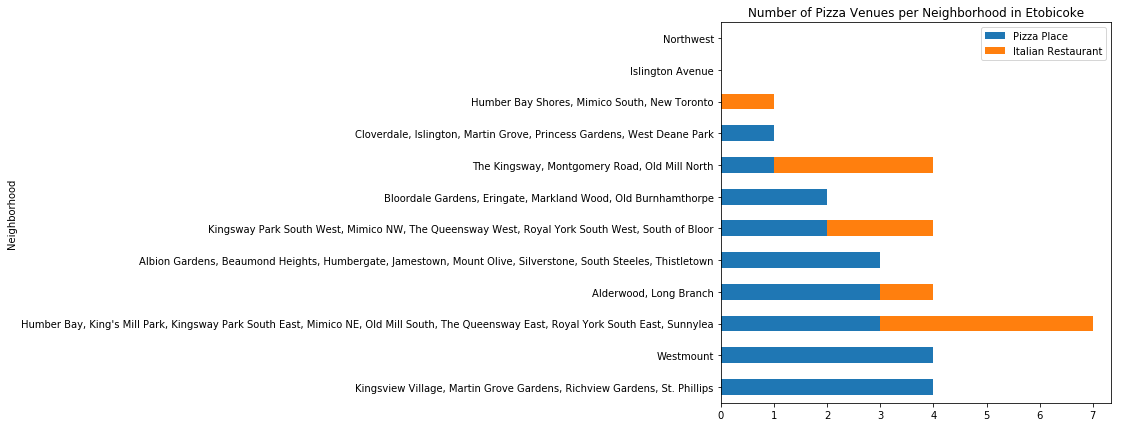

In [37]:
import matplotlib.pyplot as plt



### type your answer here
chart_df.plot(kind='barh', figsize = (7,7), stacked = True)
plt.title("Number of Pizza Venues per Neighborhood in Etobicoke")
 
    
plt.show()


